In [6]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from PIL import Image
from scipy.ndimage import uniform_filter
from scipy.ndimage import gaussian_filter
from scipy.io import loadmat
import random
import os
import scipy
from scipy.interpolate import griddata

seed_value = 1234
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [2]:
# CUDA
# if gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available")
else:
    device = torch.device('cpu')
    print("Only cpu is available")
    
torch.backends.cudnn.benchmark = True
epsilon = torch.finfo(torch.float32).eps


class DNN1(torch.nn.Module):
    def __init__(self, width):
        super(DNN1, self).__init__()
        self.width = width
        self.p = nn.Conv2d(2, self.width, 1)
        self.mlp1 = nn.Conv2d(self.width, self.width, 1) # 不缩放
        self.mlp2 = nn.Conv2d(self.width, self.width, 1)
        self.mlp3 = nn.Conv2d(self.width, self.width, 1) # 不缩放
        self.mlp4 = nn.Conv2d(self.width, self.width, 1) 
        self.q = nn.Conv2d(self.width, 2, 1)
        self.norm = nn.InstanceNorm2d(self.width)
        self.a = nn.Parameter(torch.tensor(0.2))
        
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        y = self.p(x)
        x = torch.tanh(5 * self.a *y)
        
        y = self.mlp1(x)
        y += x
        x = torch.tanh(5 * self.a *y)
        
        y = self.mlp2(x)
        y += x
        x = torch.tanh(5 * self.a *y)
        
        y = self.mlp3(x)
        y += x
        x = torch.tanh(5 * self.a *y)
        
        y = self.mlp4(x)
        y += x
        x = torch.tanh(5 * self.a *y)
        
        x = self.q(x)
        return x 

class PhysicsInformedNN1:
    def __init__(self, ref_gray_matrix, def_gray_matrix, ROI, width, IX, IY):
        
        self.Iref = torch.tensor(ref_gray_matrix, dtype=torch.float32).to(device)
        self.Idef = torch.tensor(def_gray_matrix, dtype=torch.float32).to(device)
        self.roi = torch.tensor(ROI, dtype=torch.float32).to(device)
        self.ROI = ROI
        self.IX = torch.tensor(IX, dtype=torch.float32).to(device)
        self.IY = torch.tensor(IY, dtype=torch.float32).to(device)
        self.XY = torch.stack((self.IX, self.IY), dim=2).unsqueeze(0)
        
        self.width = width
        self.window_size = 3
        self.window = torch.hann_window(self.window_size).to(device)
        self.twoD = True
        # 加载深度学习网络
        self.dnn = DNN1(self.width).to(device)
        
        self.epoch = 0
        self.loss_temp=100
        self.loss_list = []
        self.lossf_list = []
        
        # 设置优化器
        self.optimizer = torch.optim.LBFGS(self.dnn.parameters(), lr=1, 
                                           max_iter=2000, max_eval=50000,
                                           history_size=50, 
                                           tolerance_grad=1e-08, 
                                           tolerance_change=0.5 * np.finfo(float).eps,
                                           line_search_fn="strong_wolfe")
        
        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), 
                                               lr=0.001,  eps=1e-8, 
                                               weight_decay=0.0001)
        
        self.scheduler = lr_scheduler.CosineAnnealingLR(self.optimizer_adam, T_max=100)  # T_max 可以根据需要调整
        
    def smooth_hm(self, loss, twoD=False):
        matrix = loss
        if twoD == True:
            window_2d = self.window.outer(self.window)
            smoothed_matrix = F.conv2d(matrix.unsqueeze(0).unsqueeze(0), 
                                       window_2d.unsqueeze(0).unsqueeze(0), 
                                       padding=self.window_size // 2)
        else:
            window_1d = self.window
            smoothed_matrix = F.conv1d(matrix.view(1, 1, -1), 
                                       window_1d.view(1, 1, -1), 
                                       padding=self.window_size // 2)
            smoothed_matrix = smoothed_matrix.view(matrix.size())
        return smoothed_matrix
    
    def set_window(self, window_size, flag=False):
        self.window_size = window_size
        self.window = torch.hann_window(self.window_size).to(device)
        self.twoD = flag
        
    def net_f(self, UV):
        target_height = self.Idef.shape[0]
        target_width = self.Idef.shape[1]
        upscaled_displacement_field = UV
        # u = upscaled_displacement_field[0,0]/self.Idef.shape[1]  # 缩放
        # v = upscaled_displacement_field[0,1]/self.Idef.shape[0]  # 缩放
        u = upscaled_displacement_field[0,0]
        v = upscaled_displacement_field[0,1]
        # 计算 ex, ey, exy
        ex = torch.diff(u, dim=1)[1:target_height+1,:]   # (h,w)->(h,w-1)->(h-1,w-1)
        ey = torch.diff(v, dim=0)[:,1:target_width+1]    # (h,w)->(h-1,w)->(h-1,w-1)
        exy = 0.5 * (ex + ey)                            # (h-1,w-1)
        # 计算 ex1, ex2, ey1, ey2, exy1, exy2
        ex1 = torch.diff(ex, dim=1)                      # (h-1,w-1)->(h-1,w-2)
        ex2 = torch.diff(ex1, dim=1)[2:target_height,:]  # (h-1,w-2)->(h-1,w-3)->(h-3,w-3)

        ey1 = torch.diff(ey, dim=0)                      # (h-1,w-1)->(h-2,w-1)
        ey2 = torch.diff(ey1, dim=0)[:,2:target_width]   # (h-2,w-1)->(h-3,w-1)->(h-3,w-3)

        exy1 = torch.diff(exy, dim=1)[1:target_height,:] # (h-1,w-1)->(h-1,w-2)->(h-2,w-2)
        exy2 = torch.diff(exy1, dim=0)[:,1:target_width] # (h-2,w-2)->(h-3,w-2)->(h-3,w-3)
        result = torch.sum((ex2 + ey2 - exy2) ** 2)
        return result
 
    def loss_fn1(self):
        self.optimizer.zero_grad()
        UV = self.dnn(self.XY)
        loss_f = self.net_f(UV)
        upscaled_displacement_field = UV
        u = upscaled_displacement_field[0,0]/self.Idef.shape[1] * self.roi
        v = upscaled_displacement_field[0,1]/self.Idef.shape[0] * self.roi
        uv_displacement = torch.stack((u, v), dim=2).unsqueeze(0)
        
        X_new = self.XY + uv_displacement
        
        # 插值新的散斑图: 理论仿真实验用 bilinear ，实际实验用 bicubic
        new_Idef = F.grid_sample(self.Iref.view(1, 1, self.Iref.shape[0], self.Iref.shape[1]), 
                                 X_new.view(1, self.Idef.shape[0], self.Idef.shape[1], 2), 
                                 mode='bilinear', align_corners=True)
        
        # 计算两张图的相关数
        abs_error = (new_Idef[0, 0] - self.Idef)**2
        abs_error = torch.log10(1+abs_error) * self.roi
        abs_error = self.smooth_hm(abs_error, self.twoD) * self.roi    # 加窗平滑
        abs_error = abs_error.view(self.Iref.size())
        loss = 5 * torch.sum(abs_error)/(abs_error.shape[0]*abs_error.shape[1]) + loss_f * 0.01
        loss_gray = torch.abs(new_Idef[0, 0] - self.Idef)* self.roi
        loss_gray = torch.sum(loss_gray)/(loss_gray.shape[0]*loss_gray.shape[1])
        loss.backward()
        self.epoch = self.epoch+1
        if self.epoch%100 == 1:
            # print(f"Epoch [{self.epoch}], Loss: {loss.item():4f}, Abserror: {loss_gray.item():4f}")
            self.loss_list.append(loss_gray.item())
        return loss

    def loss_fn2(self):
        self.optimizer.zero_grad()
        UV = self.dnn(self.XY)
        loss_f = self.net_f(UV)
        upscaled_displacement_field = UV
        u = upscaled_displacement_field[0,0]/self.Idef.shape[1] * self.roi
        v = upscaled_displacement_field[0,1]/self.Idef.shape[0] * self.roi
        uv_displacement = torch.stack((u, v), dim=2).unsqueeze(0)
        
        X_new = self.XY + uv_displacement
        
        # 插值新的散斑图: 理论仿真实验用 bilinear ，实际实验用 bicubic
        new_Idef = F.grid_sample(self.Iref.view(1, 1, self.Iref.shape[0], self.Iref.shape[1]), 
                                 X_new.view(1, self.Idef.shape[0], self.Idef.shape[1], 2), 
                                 mode='bilinear', align_corners=True)
        
        # 计算两张图的相关数
        abs_error = (new_Idef[0, 0] - self.Idef)**2 * self.roi
        abs_error = self.smooth_hm(abs_error, self.twoD) * self.roi          # 加窗平滑
        abs_error = abs_error.view(self.Iref.size())
        loss = torch.sum(abs_error)/(abs_error.shape[0]*abs_error.shape[1]) + loss_f * 0.01
        loss_gray = torch.abs(new_Idef[0, 0] - self.Idef)* self.roi
        loss_gray = torch.sum(loss_gray)/(loss_gray.shape[0]*loss_gray.shape[1])
        loss.backward()
        self.epoch = self.epoch+1
        if self.epoch%100 == 1:   
            # print(f"Epoch [{self.epoch}], Loss: {loss.item():4f}, Abserror: {loss_gray.item():4f}")
            self.loss_list.append(loss_gray.item())
        return loss
    
    def save_model_parameter(self, loss):
        if loss.item() < 0.05:
            if loss.item() < self.loss_temp:
                self.loss_temp = loss.item()
                torch.save(self.dnn.state_dict(), f'model_checkpoint_epoch_{self.epoch}.pth')
                print(f"Model saved at epoch {self.epoch}, loss:{loss.item()}") 
         
    def train(self, flag):
        self.dnn.train()
        if flag==1:
            self.optimizer.step(self.loss_fn1)
        else:
            self.optimizer.step(self.loss_fn2)          
    
    def train_adam(self, flag, epoch):
        self.dnn.train()
        if flag==1:
            for iter in range(epoch):
                loss = self.loss_fn1()
                self.optimizer_adam.step()
                self.scheduler.step()
                #self.save_model_parameter(loss)
        else:
            for iter in range(epoch):
                loss = self.loss_fn2()
                self.optimizer_adam.step()
                self.scheduler.step()
                #self.save_model_parameter(loss)
    
    def predict(self, X, Y):
        self.dnn.eval()
        Ixy = np.stack((X, Y), axis=-1)
        Ixy = torch.tensor(Ixy, dtype=torch.float32).unsqueeze(0).to(device)
        U = self.dnn(Ixy)
        u = U[:,0]
        u = u.cpu().detach().numpy()
        v = U[:,1]
        v = v.cpu().detach().numpy()
        return u, v
    
    def abs_error_var(self):
        UV = self.dnn(self.XY)
        upscaled_displacement_field = UV
        u = upscaled_displacement_field[0,0]/self.Idef.shape[1] * self.roi
        v = upscaled_displacement_field[0,1]/self.Idef.shape[0] * self.roi
        uv_displacement = torch.stack((u, v), dim=2).unsqueeze(0)
        X_new = self.XY + uv_displacement
        # 插值新的散斑图: 理论仿真实验用 bilinear ，实际实验用 bicubic
        new_Idef = F.grid_sample(self.Iref.view(1, 1, self.Iref.shape[0], self.Iref.shape[1]), 
                                 X_new.view(1, self.Idef.shape[0], self.Idef.shape[1], 2), 
                                 mode='bilinear', align_corners=True)
        # 计算两张图的相关数
        abs_error = (new_Idef[0, 0] - self.Idef)**2
        abs_error = abs_error.cpu().detach().numpy()
        return abs_error

CUDA is available


In [19]:
def DIC_Strain_from_Displacement(u, v, flag, step, SmoothLen):
    u = u.T
    v = v.T
    flag = flag.T

    m = SmoothLen
    if m % 2 == 0:  # 判断m是不是奇数
        m += 1  # m必须为奇数
    hfm = (m - 1) // 2

    # 扩展矩阵
    uc = np.full((u.shape[0] + 2*hfm, u.shape[1] + 2*hfm), np.nan)
    vc = np.full((v.shape[0] + 2*hfm, v.shape[1] + 2*hfm), np.nan)
    flag_c = np.zeros((flag.shape[0] + 2*hfm, flag.shape[1] + 2*hfm))
    ny, nx = uc.shape
    
    uc[hfm:ny-hfm, hfm:nx-hfm] = u
    vc[hfm:ny-hfm, hfm:nx-hfm] = v
    
    # print(len(range(hfm,ny-hfm)))
    flag_c[hfm:ny-hfm, hfm:nx-hfm] = flag

    Ex = np.full(u.shape, np.nan)
    Ey = np.full(u.shape, np.nan)
    Exy = np.full(u.shape, np.nan)

    for i in range(nx - 2*m):
        for j in range(ny - 2*m):
            if flag[j, i] == 0:
                continue

            # print(f"i:{i}, j:{j}")
            startx = i
            starty = j

            stopx = startx + m
            stopy = starty + m

            uu = u[starty:stopy, startx:stopx]
            vv = v[starty:stopy, startx:stopx]
            FLAG = flag[starty:stopy, startx:stopx]
            X, Y = np.meshgrid(np.arange(-hfm, hfm+1), np.arange(-hfm, hfm+1))
            xx = X * step
            yy = Y * step

            X = np.column_stack((np.ones(m**2), yy.flatten(), xx.flatten()))

            f_valid = np.where(FLAG.flatten() == 1)[0]
            # print(f"f_valid.shape:{f_valid.shape}")

            if len(f_valid) > 0:
                if np.sum(FLAG) > 3:
                    f_invalid = np.where(FLAG.flatten() == 0)[0]
                    U = uu.flatten()[f_valid]
                    V = vv.flatten()[f_valid]
                    X = np.delete(X, f_invalid, axis=0)
                    U = np.delete(U, f_invalid)
                    V = np.delete(V, f_invalid)

                    # print(f"X.shape: {X.shape}, U.shape: {U.shape}, V.shape: {V.shape}")
                    a = np.linalg.lstsq(X, U, rcond=None)[0]
                    b = np.linalg.lstsq(X, V, rcond=None)[0]
                else:
                    a = np.full(3, np.nan)
                    b = np.full(3, np.nan)
            else:
                a = np.full(3, np.nan)
                b = np.full(3, np.nan)

            Ex[j, i] = a[1]
            Ey[j, i] = b[2]
            Exy[j, i] = (a[2] + b[1]) / 2

    return Ex.T, Ey.T, Exy.T

def interpolate_matrix(uu, new_shape):
    non_nan_rows = np.any(~np.isnan(uu), axis=1)
    row_indices = np.where(non_nan_rows)[0]
    non_nan_columns = np.any(~np.isnan(uu), axis=0)
    column_indices = np.where(non_nan_columns)[0]
    matrix = uu[row_indices[:, np.newaxis], column_indices]
    x_list = np.linspace(0,1,matrix.shape[1])
    y_list = np.linspace(0,1,matrix.shape[0])
    x_grid, y_grid = np.meshgrid(x_list, y_list)  
    X_star = np.hstack((x_grid.flatten()[:,None], y_grid.flatten()[:,None]))
    z_grid = matrix.flatten()[:,None]
    x_list = np.linspace(0,1,new_shape[1])
    y_list = np.linspace(0,1,new_shape[0])
    x_new, y_new = np.meshgrid(x_list, y_list)
    U = griddata(X_star, z_grid, (x_new, y_new), method='cubic')
    return U

In [18]:
x_list = np.linspace(0,1,400)
y_list = np.linspace(0,1,200)
x_new, y_new = np.meshgrid(x_list, y_list)
print(x_new.shape)

(200, 400)


In [4]:
ref_image = Image.open('./speckle image/000.bmp')
ref_gray = ref_image.convert('L')
ref_gray = np.array(ref_gray)
RG = ref_gray[290:500,530:950]

DG_list = []
for i in range(1, 15):
    # 构建文件名
    file_name = '{:03d}.bmp'.format(i)
    file_path = os.path.join('./speckle image/', file_name)
    # 读取图像并转换为灰度矩阵
    image = Image.open(file_path)
    gray_image = image.convert('L')
    gray_array = np.array(gray_image)
    DG = gray_array[290:500,530:950]
    DG_list.append(DG)
DG_array = np.array(DG_list)

xstart_index = 5
ystart_index = 5
yend_index = DG.shape[0] - 5
xend_index = DG.shape[1] - 5

ROI = np.zeros_like(DG)
ROI[ystart_index:yend_index, xstart_index:xend_index] = 1
u_list = []; v_list = []; exx_list = []

In [11]:
print(Exx.shape)
print(u_sub.shape)

(410, 200)
(200, 410)


(200, 410)

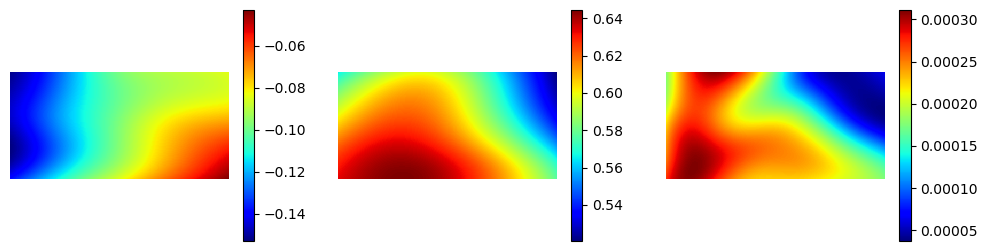

In [30]:
y_size, x_size = RG.shape
x_list = np.linspace(-1, 1, x_size)
y_list = np.linspace(-1, 1, y_size)
IX, IY = np.meshgrid(x_list, y_list)
# 网络结构
width = 50

model = PhysicsInformedNN1(RG, DG_array[6], ROI, width, IX, IY)
model.train_adam(1, 200)
# model.train(1)
model.train_adam(2, 100)
# model.train(2)
u,v = model.predict(IX, IY)
u = -u[0]/2
v = -v[0]/2
u_sub = u[ystart_index:yend_index, xstart_index:xend_index]
v_sub = v[ystart_index:yend_index, xstart_index:xend_index]

flag_P = np.ones_like(u_sub)
step = 1
SmoothLen_P = 15
Exx_P, Eyy_P, Exy_P = DIC_Strain_from_Displacement(u_sub, v_sub, flag_P, step, SmoothLen_P)
Exx = interpolate_matrix(Exx_P, u_sub.shape)

plt.figure(figsize=(12, 3))
plt.subplot(1,3,1)
plt.imshow(u_sub, cmap='jet', interpolation='nearest') # , norm=normu
plt.colorbar()
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(v_sub, cmap='jet', interpolation='nearest') # , norm=normv
plt.colorbar()
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(Exx, cmap='jet', interpolation='nearest') # , norm=normv
plt.colorbar()
plt.axis('off')
u_sub.shape
# model = PhysicsInformedNN1(RG, DG, ROI, width, IX, IY)
# model.dnn.load_state_dict(torch.load('crack_003_resnet2.pth'))
# u,v = model.predict(IX, IY)
# u = -u[0]/2; v = -v[0]/2
# u_sub = u[xstart_index:xend_index, ystart_index:yend_index]
# v_sub = v[xstart_index:xend_index, ystart_index:yend_index]
# u_list.append(u_sub); v_list.append(v_sub)

In [96]:
# import scipy
# from scipy.interpolate import griddata
# Exx_P = interpolate_matrix(Exx_P, u_sub.shape)
# data_to_save = {'exx_pinn': Exx_P, 'u_sub': u_sub, 'v_sub': v_sub}
# scipy.io.savemat(f'crack_003_02.mat', data_to_save)

In [101]:
u_list.append(u_sub); v_list.append(v_sub); exx_list.append(Exx)
# i = 8
# u_sub = u_list[i]; v_sub = v_list[i]
# plt.figure(figsize=(12, 3))
# plt.subplot(1, 2, 1)
# plt.imshow(u_sub, cmap='jet', interpolation='nearest') # , norm=normu
# plt.colorbar()
# plt.axis('off')
# plt.subplot(1, 2, 2)
# plt.imshow(v_sub, cmap='jet', interpolation='nearest') # , norm=normv
# plt.colorbar()
# plt.axis('off')
# u_sub.shape

In [62]:
exx_list = []
flag_P = np.ones_like(u_sub)
step = 1
SmoothLen_P = 15
for i in range(9):
    u_sub = u_list[i]; v_sub = v_list[i]
    Exx_P, Eyy_P, Exy_P = DIC_Strain_from_Displacement(u_sub, v_sub, flag_P, step, SmoothLen_P)
    exx_list.append(Exx_P)

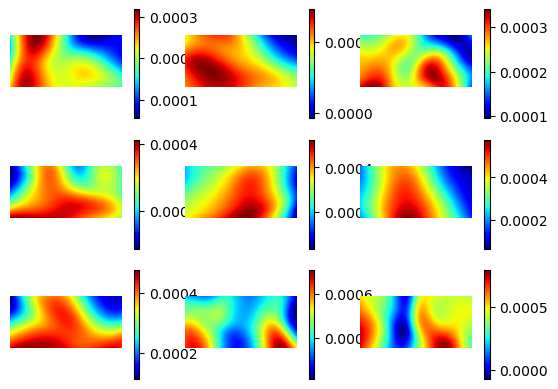

In [64]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(exx_list[i], cmap='jet', interpolation='nearest') # 
    plt.colorbar()
    plt.axis('off')

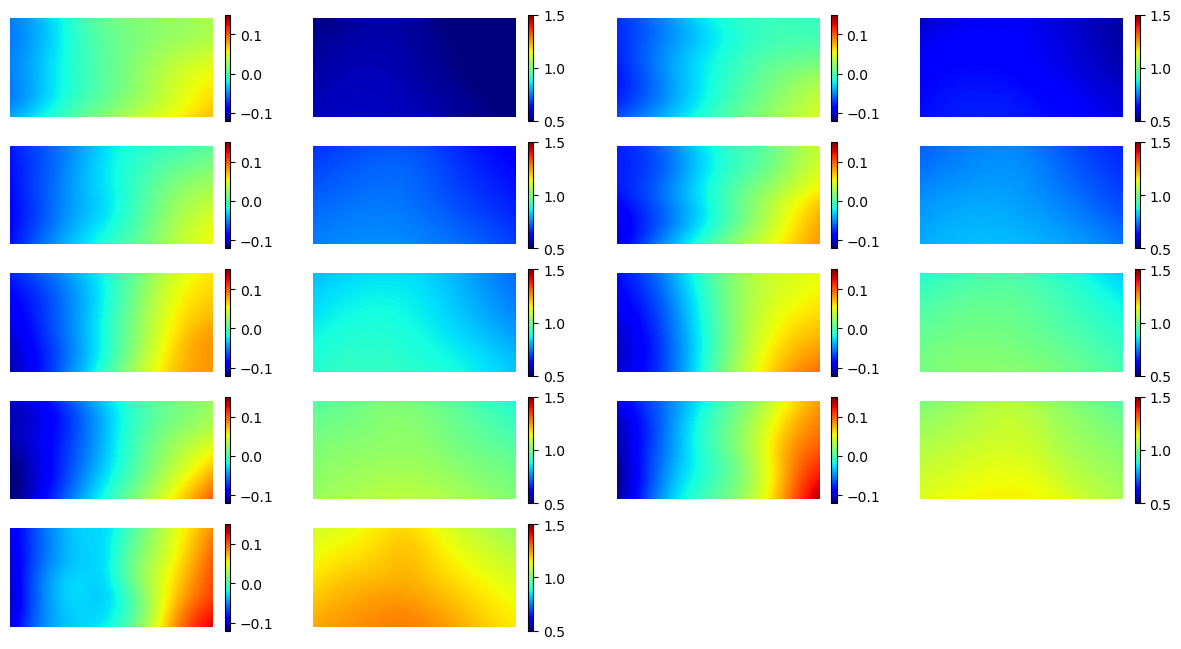

In [59]:
u_array = np.array(u_list)*1.2
v_array = np.array(v_list)*1.01
add_list = [0.09, 0.10, 0.05, 0.08, 0.08, 0.05, 0.02, 0, -0.03]
for i in range(9):
    u_array[i] = u_array[i] + add_list[i]
vmin_u=-0.12; vmax_u=0.15; vmin_v=0.5; vmax_v=1.5
normu = matplotlib.colors.Normalize(vmin=vmin_u, vmax=vmax_u)
normv = matplotlib.colors.Normalize(vmin=vmin_v, vmax=vmax_v)
plt.figure(figsize=(15, 8),dpi=100)
for i in range(9):
    plt.subplot(5, 4, (i)*2+1)
    plt.imshow(u_array[i], cmap='jet', interpolation='nearest', norm=normu) # 
    plt.colorbar()
    plt.axis('off')
    plt.subplot(5, 4, (i)*2+2)
    plt.imshow(v_array[i], cmap='jet', interpolation='nearest', norm=normv) # 
    plt.colorbar()
    plt.axis('off')
# indices = [5, 6, 7, 8, 9, 10, 12, 13]
# up = u_array[indices]
# vp = v_array[indices]

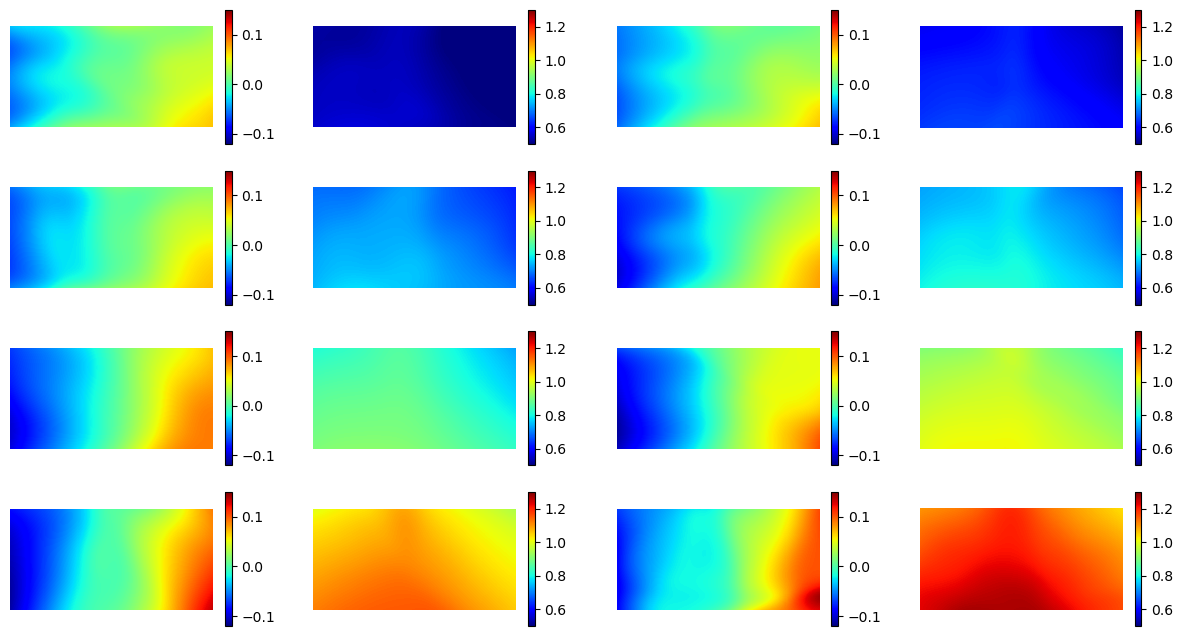

In [127]:
vmin_u=-0.12; vmax_u=0.15; vmin_v=0.5; vmax_v=1.3
normu = matplotlib.colors.Normalize(vmin=vmin_u, vmax=vmax_u)
normv = matplotlib.colors.Normalize(vmin=vmin_v, vmax=vmax_v)
plt.figure(figsize=(15, 8),dpi=100)
for i in range(up.shape[0]):
    plt.subplot(4, 4, (i)*2+1)
    plt.imshow(up[i], cmap='jet', interpolation='nearest', norm=normu) # 
    plt.colorbar()
    plt.axis('off')
    plt.subplot(4, 4, (i)*2+2)
    plt.imshow(vp[i], cmap='jet', interpolation='nearest', norm=normv) # 
    plt.colorbar()
    plt.axis('off')

In [130]:
u_struct = {}; v_struct = {}
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
for i in range(8):
    field_name = letters[i]
    u_struct[field_name] = up[i]
    v_struct[field_name] = vp[i]


In [131]:
from scipy.io import savemat
data_dict = {
    'u': u_struct,
    'v': v_struct
}
savemat('./U(time).mat', data_dict)

(200, 400)


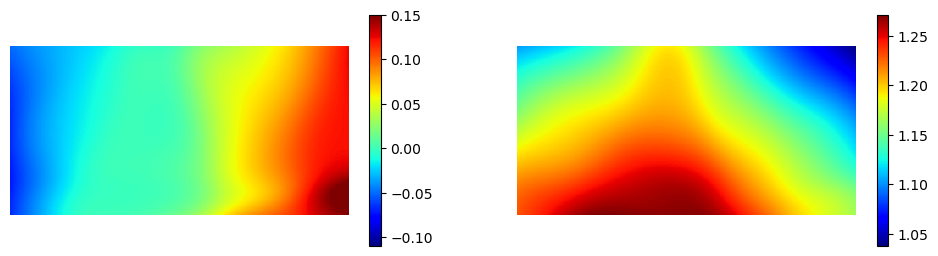

In [104]:
i = 13
plt.figure(figsize=(12, 3))
plt.subplot(1,2,1)
normu = matplotlib.colors.Normalize(vmin=0.15, vmax=-0.1)
plt.imshow(u_array[i]+0.0, cmap='jet', interpolation='nearest', norm=normu) # 
plt.colorbar()
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(v_array[i], cmap='jet', interpolation='nearest') # 
plt.colorbar()
plt.axis('off')
print(u_list[i].shape)

5: +0.09
6: +0.12
7: +0.07
8: +0.08
9: +0.09
10: +0.05
11: +0.02
12: +0
13: +0

(-0.5, 399.5, 199.5, -0.5)

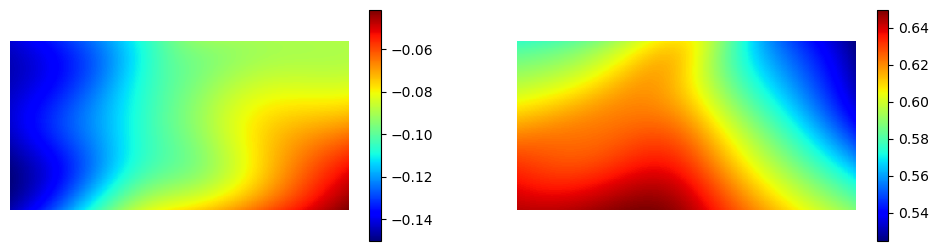

In [89]:
y_size, x_size = RG.shape
x_list = np.linspace(-1, 1, x_size)
y_list = np.linspace(-1, 1, y_size)
IX, IY = np.meshgrid(x_list, y_list)
# 网络结构
width = 50

model = PhysicsInformedNN1(RG, DG_array[6], ROI, width, IX, IY)
model.train_adam(1, 700)
model.train_adam(2, 700)
# model.train(1)
u,v = model.predict(IX, IY)
u = -u[0]/2
v = -v[0]/2

vmin_u=-0.042
vmax_u=0.15
vmin_v=1.0817
vmax_v=1.2586

xstart_index = 5
ystart_index = 10
xend_index = u.shape[0] - 5
yend_index = u.shape[1] - 10
u_sub = u[xstart_index:xend_index, ystart_index:yend_index]
v_sub = v[xstart_index:xend_index, ystart_index:yend_index] 

plt.figure(figsize=(12, 3))
normu = matplotlib.colors.Normalize(vmin=vmin_u, vmax=vmax_u)
normv = matplotlib.colors.Normalize(vmin=vmin_v, vmax=vmax_v)
plt.subplot(1, 2, 1)
plt.imshow(u_sub, cmap='jet', interpolation='nearest') # , norm=normu
plt.colorbar()
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(v_sub, cmap='jet', interpolation='nearest') # , norm=normv
plt.colorbar()
plt.axis('off')

Epoch [2201], Loss: 23.722822, Abserror: 1.947425


(-0.5, 409.5, 199.5, -0.5)

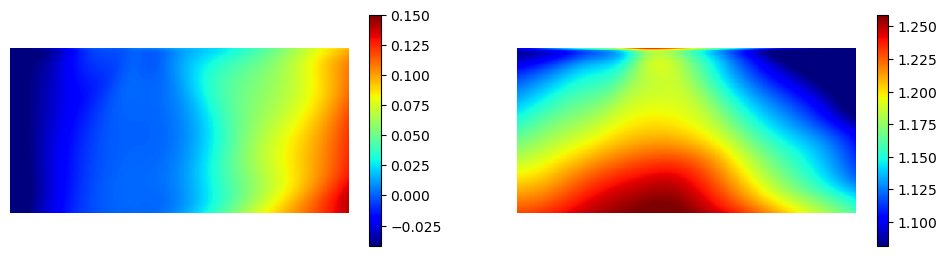

In [20]:
model.train_adam(2, 100)
u,v = model.predict(IX, IY)
u = -u[0]/2
v = -v[0]/2
u_sub = u[xstart_index:xend_index, ystart_index:yend_index]
v_sub = v[xstart_index:xend_index, ystart_index:yend_index] 

plt.figure(figsize=(12, 3))
normu = matplotlib.colors.Normalize(vmin=vmin_u, vmax=vmax_u)
normv = matplotlib.colors.Normalize(vmin=vmin_v, vmax=vmax_v)
plt.subplot(1, 2, 1)
plt.imshow(u_sub, cmap='jet', interpolation='nearest', norm=normu) # , norm=normu
plt.colorbar()
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(v_sub, cmap='jet', interpolation='nearest', norm=normv) # , norm=normv
plt.colorbar()
plt.axis('off')

(-0.5, 409.5, 199.5, -0.5)

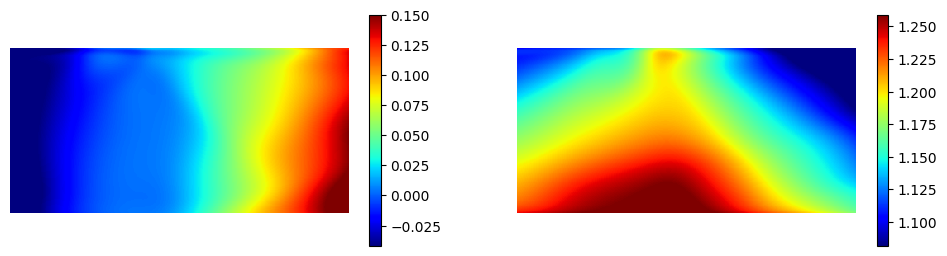

In [61]:
model = PhysicsInformedNN1(RG, DG, ROI, width, IX, IY)
model.dnn.load_state_dict(
    torch.load(
        r'D:\Jupyter\PINN in DIC\model parameters\crack_003_resnet2.pth'
    )
)
u,v = model.predict(IX, IY)
u = -u[0]/2*1.2
v = -v[0]/2*1.01

vmin_u=-0.042
vmax_u=0.15
vmin_v=1.0817
vmax_v=1.2586

xstart_index = 5
ystart_index = 5
xend_index = u.shape[0] - 5
yend_index = u.shape[1] - 5
u_sub = u[xstart_index:xend_index, ystart_index:yend_index]
v_sub = v[xstart_index:xend_index, ystart_index:yend_index] 

plt.figure(figsize=(12, 3))
normu = matplotlib.colors.Normalize(vmin=vmin_u, vmax=vmax_u)
normv = matplotlib.colors.Normalize(vmin=vmin_v, vmax=vmax_v)
plt.subplot(1, 2, 1)
plt.imshow(u_sub, cmap='jet', interpolation='nearest', norm=normu) # , norm=normu
plt.colorbar()
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(v_sub, cmap='jet', interpolation='nearest', norm=normv) # , norm=normv
plt.colorbar()
plt.axis('off')

(-1.0, 1.0, -1.0, 1.0)

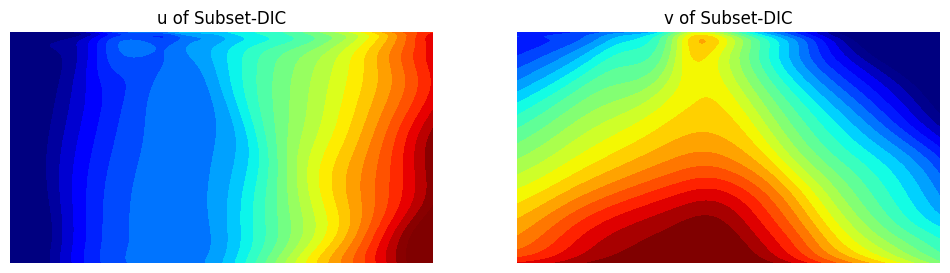

In [60]:
## 等值图
u_sub1 = np.flip(u_sub, axis=0)
v_sub1 = np.flip(v_sub, axis=0)
N = 30
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
c1 = ax1.contourf(X, Y, u_sub1*1.2, N, cmap='jet', vmin=vmin_u, vmax=vmax_u)
ax1.set_title('u of Subset-DIC')
ax1.axis('off')

c2 = ax2.contourf(X, Y, v_sub1*1.01, N, cmap='jet', vmin=vmin_v, vmax=vmax_v)
ax2.set_title('v of Subset-DIC')
ax2.axis('off')

In [62]:
# from scipy.io import savemat
# data_dict = {
#     'u_sub': u_sub,
#     'v_sub': v_sub,
#     'u_dic': u_dic,
#     'v_dic': v_dic
# }
# savemat(r'D:\Jupyter\PINN in DIC\STAR_displacement_plot\pinn_crack.mat', data_dict)

Text(0.5, 1.0, 'Deformed Image')

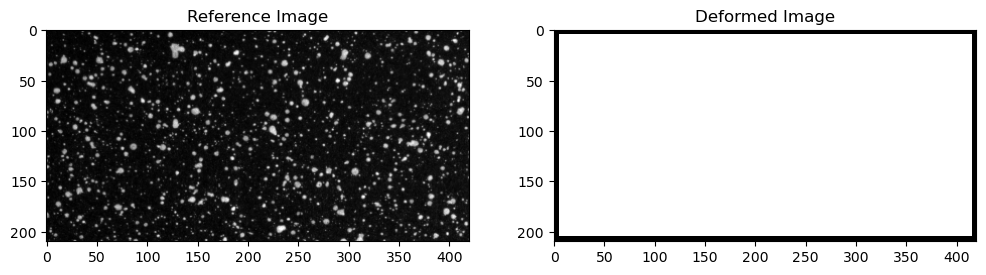

In [30]:
ref_image = Image.open('./speckle image/000.bmp')
ref_gray = ref_image.convert('L')
ref_gray = np.array(ref_gray)
RG = ref_gray[290:500,530:950]

def_image = Image.open('./speckle image/014.bmp')
def_gray = def_image.convert('L')
def_gray = np.array(def_gray)
DG = def_gray[290:500,530:950]

xstart_index = 5
ystart_index = 5
yend_index = DG.shape[0] - 5
xend_index = DG.shape[1] - 5

ROI = np.zeros_like(DG)
ROI[ystart_index:yend_index, xstart_index:xend_index] = 1

roi = np.zeros_like(DG)
roi[ystart_index:yend_index, xstart_index:xend_index] = 255

# sigma = 0.0  # 高斯核的标准差，可以根据需要调整
# RG = gaussian_filter(RG, sigma=sigma)
# DG = gaussian_filter(DG, sigma=sigma)

# # 绘制原始图像和插值后的图像
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.imshow(RG, cmap='gray')
plt.title('Reference Image')
plt.subplot(1, 2, 2)
plt.imshow(ROI, cmap='gray')
plt.title('Deformed Image')